In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import spacy
import string
from sklearn.model_selection import train_test_split

import time
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from scipy import sparse
import warnings
warnings.filterwarnings("ignore")

# **Load the Dataset**

In [ ]:
dataset = pd.read_csv('BBC News Train.csv')
# test_set = pd.read_csv("BBC News Test.csv")

In [ ]:
dataset.head(5)

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [ ]:
target_category = dataset['Category'].unique()
print(target_category)

['business' 'tech' 'politics' 'sport' 'entertainment']


In [ ]:
dataset['categoryId'] = dataset['Category'].factorize()[0]
dataset.head()

,ArticleId,Text,Category,categoryId
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,1
4,917,enron bosses in $168m payout eighteen former e...,business,0


**Class labels**

In [ ]:
category = dataset[["Category","categoryId"]].drop_duplicates().sort_values('categoryId')
category

,Category,categoryId
0,business,0
3,tech,1
5,politics,2
6,sport,3
7,entertainment,4


**Class Distribution**

In [ ]:
dataset.groupby('Category').categoryId.count()

Category
business         336
entertainment    273
politics         274
sport            346
tech             261
Name: categoryId, dtype: int64

**Data Visualization**

<Axes: xlabel='Category'>

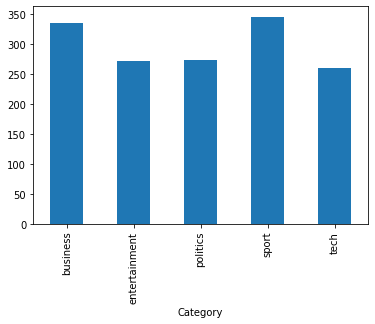

In [ ]:
dataset.groupby('Category').categoryId.count().plot.bar(ylim=0)

**We have confirmed 5 categories for our news articles: business, tech, politics, sport, and entertainment.we can see that our data is roughly balanced.**

# **Data Preprocessing**

**i)Clean the text by removing punctuation, stop words, and converting all text to
lowercase.**

**1)Lower Casing**

*Lower casing is a common text preprocessing technique. The idea is to convert the input text into same casing format so that 'text', 'Text' and 'TEXT' are treated the same way.*

In [ ]:
dataset["Text"] = dataset["Text"].str.lower()
dataset.head()

,ArticleId,Text,Category,categoryId
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,1
4,917,enron bosses in $168m payout eighteen former e...,business,0


**2)Removal of Punctuations**

*One another common text preprocessing technique is to remove the punctuations from the text data. This is again a text standardization process that will help to treat 'hurray' and 'hurray!' in the same way.*

In [ ]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

dataset["Text"] = dataset["Text"].apply(lambda text: remove_punctuation(text))
dataset.head()

,ArticleId,Text,Category,categoryId
0,1833,worldcom exboss launches defence lawyers defen...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,1
4,917,enron bosses in 168m payout eighteen former en...,business,0


**Remove Numbers**

In [ ]:
def remove_numbers_boundaries(text):
    """Remove boundaries of words containing numbers"""
    pattern = r"\b\w*\d\w*\b"
    return re.sub(pattern, "", text)

dataset["Text"] = dataset["Text"].apply(remove_numbers_boundaries)
dataset.head(5)

,ArticleId,Text,Category,categoryId
0,1833,worldcom exboss launches defence lawyers defen...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,1
4,917,enron bosses in payout eighteen former enron ...,business,0


**3)Removal of stopwords**

*Stopwords are commonly occuring words in a language like 'the', 'a' and so on. They can be removed from the text most of the times, as they don't provide valuable information for downstream analysis.*

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [ ]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

dataset["Text"] = dataset["Text"].apply(lambda text: remove_stopwords(text))
dataset.head()


,ArticleId,Text,Category,categoryId
0,1833,worldcom exboss launches defence lawyers defen...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens maj...,business,0
3,1976,lifestyle governs mobile choice faster better ...,tech,1
4,917,enron bosses payout eighteen former enron dire...,business,0


**Remove Numbers**

In [ ]:
# def remove_standalone_digits(text):
#     """Replace standalone digits with spaces"""
#     words = text.split()
#     new_words = []
#     for word in words:
#         if word.isdigit():  # check if the entire word is a digit
#             new_words.append('')  # replace the entire word with a space
#         else:
#             # replace standalone digits within the word with a space
#             new_word = re.sub(r'\b\d+\b', '', word)
#             new_words.append(new_word)
#     return ' '.join(new_words)

In [ ]:
# import re
# def replace_numbers_with_space(text):
#     """Replace any numbers in the text with a space character"""
#     words = text.split()
#     words = [re.replace(r'\b\d+\b', '', word) for word in words]  # replace standalone digits
#     return ' '.join(words)


# dataset["Text"] = dataset["Text"].apply(lambda text: remove_numbers_boundaries(text))
# dataset.head(5)


**Perform lemmatization to reduce words to their root form.**

*Stemming is the process of reducing inflected (or sometimes derived) words to their word stem, base or root form (From Wikipedia)*

In [ ]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

dataset["Text"] = dataset["Text"].apply(lambda text: lemmatize_words(text))
dataset.head()

,ArticleId,Text,Category,categoryId
0,1833,worldcom exboss launch defence lawyer defend f...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicate economic gloom citizen major...,business,0
3,1976,lifestyle governs mobile choice faster well fu...,tech,1
4,917,enron boss payout eighteen former enron direct...,business,0


**Converting every articles into tokens after text preprocessing**

In [ ]:
!pip install --user -U nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
text = dataset.iloc[0]["Text"]
print(text)

worldcom exboss launch defence lawyer defend former worldcom chief bernie ebbers battery fraud charge call company whistleblower first witness cynthia cooper worldcom exhead internal accounting alert director irregular accounting practice u telecoms giant warning lead collapse firm follow discovery £ accounting fraud mr ebbers plead guilty charge fraud conspiracy prosecution lawyer argue mr ebbers orchestrate series accounting trick worldcom order employee hide expense inflate revenue meet wall street earnings estimate ms cooper run consult business tell jury new york wednesday external auditor arthur andersen approve worldcom account early say andersen give green light procedure practice use worldcom mr ebber lawyer say unaware fraud argue auditor alert problem ms cooper also say shareholder meeting mr ebbers often pass technical question company finance chief give brief answer prosecution star witness former worldcom financial chief scott sullivan say mr ebbers order accounting adjus

In [ ]:
from nltk.tokenize import word_tokenize
tokens = word_tokenize(text)
print(tokens)

['worldcom', 'exboss', 'launch', 'defence', 'lawyer', 'defend', 'former', 'worldcom', 'chief', 'bernie', 'ebbers', 'battery', 'fraud', 'charge', 'call', 'company', 'whistleblower', 'first', 'witness', 'cynthia', 'cooper', 'worldcom', 'exhead', 'internal', 'accounting', 'alert', 'director', 'irregular', 'accounting', 'practice', 'u', 'telecoms', 'giant', 'warning', 'lead', 'collapse', 'firm', 'follow', 'discovery', '£', 'accounting', 'fraud', 'mr', 'ebbers', 'plead', 'guilty', 'charge', 'fraud', 'conspiracy', 'prosecution', 'lawyer', 'argue', 'mr', 'ebbers', 'orchestrate', 'series', 'accounting', 'trick', 'worldcom', 'order', 'employee', 'hide', 'expense', 'inflate', 'revenue', 'meet', 'wall', 'street', 'earnings', 'estimate', 'ms', 'cooper', 'run', 'consult', 'business', 'tell', 'jury', 'new', 'york', 'wednesday', 'external', 'auditor', 'arthur', 'andersen', 'approve', 'worldcom', 'account', 'early', 'say', 'andersen', 'give', 'green', 'light', 'procedure', 'practice', 'use', 'worldcom

In [ ]:
type(tokens)

list

In [ ]:
dataset['tokens'] =0

In [ ]:
from nltk.tokenize import word_tokenize
def tokensz(data):
    data['tokens'] = data['Text'].apply(word_tokenize)
    return data

In [ ]:
dataset = tokensz(dataset)

In [ ]:
dataset.head(5)

,ArticleId,Text,Category,categoryId,tokens
0,1833,worldcom exboss launch defence lawyer defend f...,business,0,"[worldcom, exboss, launch, defence, lawyer, de..."
1,154,german business confidence slides german busin...,business,0,"[german, business, confidence, slides, german,..."
2,1101,bbc poll indicate economic gloom citizen major...,business,0,"[bbc, poll, indicate, economic, gloom, citizen..."
3,1976,lifestyle governs mobile choice faster well fu...,tech,1,"[lifestyle, governs, mobile, choice, faster, w..."
4,917,enron boss payout eighteen former enron direct...,business,0,"[enron, boss, payout, eighteen, former, enron,..."


In [ ]:
dataset.shape

(1490, 5)

**Total unique words - 21092**

In [ ]:
# Create a set of all unique words in the dataset
vocab = set()
for article in dataset['Text']:
    for word in article.split():
        vocab.add(word)

In [ ]:

len(vocab)

21092

**Vectorize the Text Data**

In [ ]:

def build_BBC_matrix(train_data):

  from sklearn.feature_extraction.text import CountVectorizer
  import pandas as pd

  vocab = set()
  for article in train_data['Text']:
     for word in article.split():
         vocab.add(word)
  print(len(vocab))

  # Create a CountVectorizer object
  vectorizer = CountVectorizer(vocabulary=vocab)


  # Fit the vectorizer to the text data
  X = vectorizer.fit_transform(train_data['Text'])

  feature_names = vectorizer.get_feature_names_out()



  # Create a DataFrame with the vectorized data and the article IDs as the index
  BBC_data_matrix = pd.DataFrame(X.toarray(), columns = feature_names)
  print(BBC_data_matrix.shape)
  # Add a Category column to BBC_data_matrix and populate it with the category labels
  BBC_data_matrix['Category']  = 'nan'
  for index in range(BBC_data_matrix.shape[0]):
    BBC_data_matrix['Category'].iloc[index] = train_data['Category'].iloc[index]


  #BBC_data_matrix['CategoryID'] = y_train['categoryId'].values

  # Print the Category column to verify that it has been added correctly
  return BBC_data_matrix

In [ ]:
# # for word in vocab:
  #     tf_icf[word] = {}
  #     for category in categories:
  #         tf_icf[word][category] = 0
           #print(tf_icf[word][category])
          #tf_icf[word] = {}
          #tf_icf[word][category] = 0
          # tf_icf[word][category] = tf[category].get(word) * math.log10(num_classes / cf[word])

**Calculate TF-ICF**

In [ ]:
# ncols = len(list(BBC_data_matrix.columns)) - 2
# cols = list(BBC_data_matrix.columns)
# for artcID in BBC_data_matrix.index:
#   art_category = BBC_data_matrix.loc[artcID]['Category']
#   for i in range(ncols):
#     if(BBC_data_matrix.loc[artcID][cols[i]] != 0):
#       tf_icf_cols = tf_icf_df.loc[cols[i]][art_category]
#       BBC_data_matrix.loc[artcID][cols[i]] =  BBC_data_matrix.loc[artcID][cols[i]] * tf_icf_cols 
    

In [ ]:
# for i in BBC_data_matrix.index:
#   if BBC_data_matrix.loc[i]['££']>0:
#         print(i)

In [ ]:
# # get the number of columns in the dataframe
# ncols = BBC_data_matrix.shape[1] - 2

# # get a list of column names
# cols = BBC_data_matrix.columns.tolist()

# # loop over the columns and update the values in the dataframe
# for col in cols[:-2]:
#     # get the row of tf-idf values for the current column and category
#     tf_icf_row = tf_icf_df.loc[col, BBC_data_matrix['Category']]
#     #print(col)
#     #multiply the tf-idf values with the original values in the dataframe
#     BBC_data_matrix[col] = BBC_data_matrix[col] * tf_icf_row.values


In [ ]:
import math
import pandas as pd

def make_tf_icf(train_data):

# Define categories
  categories = train_data['Category'].unique()
  # Compute TF for each category
  tf = {}
  for category in categories:
      articles = train_data[train_data['Category'] == category]
      article_count = len(articles)
      tf[category] = {}
      for article in articles['Text']:
          #print(article)
          for word in article.split():
              tf[category][word] = tf[category].get(word, 0) + 1

  # Compute CF and ICF for each term and category
  num_classes = len(categories)
  cf = {}
  # Compute TF-ICF scores for all words in each category
  tf_icf = {}
 
  for category in categories:
      for article in tf[category]:
          word = article
          cf[word] = len([category for category in categories if word in tf[category]])
          #print(cf[word])
          tf_icf[word] = tf_icf.get(word, {})
          tf_icf[word][category] = float(tf[category].get(word)) * float(math.log10(num_classes / cf[word]))
 
  # Create DataFrame of TF-ICF scores
  tf_icf_df = pd.DataFrame(tf_icf)
  # Transpose the DataFrame
  tf_icf_df = tf_icf_df.transpose()

  # Display the DataFrame
  return tf_icf


In [ ]:
make_tf_icf(dataset)

In [ ]:
# cols = BBC_data_matrix.columns
# tf_dict = {col: tf[col] for col in cols}

# for artcID, row in BBC_data_matrix.iterrows():
#     art_category = row['Category']
#     for col in cols[:-1]:
#         cell_value = row[col]
#         if cell_value != 0:
#             tf_icf = tf_dict[col][art_category]
#             print(cell_value)
#             row[col] = tf_icf

In [ ]:
# BBC_data_matrix.iloc[:, 5000:7000]

In [ ]:
# cols = list(BBC_data_matrix.columns)
# for artcID, row in BBC_data_matrix.iterrows():
#   art_category = row['Category']
#   for col_name in cols[:-1]:
#     print(artcID)
#     col_value = row[col_name]
#     if col_value != 0:
#       tf_icf_col = tf.get(col_name, {}).get(art_category, 0)
#       row[col_name] =  tf_icf_col

In [ ]:
# import pandas as pd
# from sklearn.feature_extraction.text import CountVectorizer

# # Sample data
# data = {
#     "ArticleId": [1833, 154, 1101, 1976, 917],
#     "Text": [
#         "worldcom ex-boss launches defence lawyers defe...",
#         "german business confidence slides german busin...",
#         "bbc poll indicates economic gloom citizens in ...",
#         "lifestyle governs mobile choice faster bett...",
#         "enron bosses in $168m payout eighteen former e..."
#     ]
# }

# # Convert data to dataframe
# df = pd.DataFrame(data)

# # Initialize CountVectorizer with n-gram range from 1 to 3
# vectorizer = CountVectorizer(ngram_range=(2, 2))

# # Fit and transform the text data to n-gram vectorized form
# ngram_matrix = vectorizer.fit_transform(df["Text"])

# # Create a new dataframe with the n-gram matrix and article ID as index
# ngram_df = pd.DataFrame(
#     ngram_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=df["ArticleId"]
# )

# # Display the n-gram dataframe
# print(ngram_df)

# **Naive Bayes Classifier**

In [ ]:
def predict_documents(docs,nb_prior_proba,words_proba):
  #Create an empty dictionary to store the posterior probabilities for each category
  nb_posterior_proba = {}
  #Create an empty list to store the predicted category for each document
  y_pred = []
    #preprocess the data
  for index, article in docs.iterrows():
      for category in nb_prior_proba:

      # Calculate the log prior probability for the category
        nb_posterior_proba[category] = nb_prior_proba[category]
        #print(nb_posterior_proba[category])
        for words in article['Text'].split():

     # If the feature (word) is in the vocabulary for the category, calculate its probability
          if( words in words_proba[category] ):
            feature_proba = words_proba[category][words]

             # Handle the case when the feature probability is 0
            if math.isclose(feature_proba,0):
              feature_proba = 0.0
            nb_posterior_proba[category]  = nb_posterior_proba[category] + feature_proba
          else:
    # If the feature (word) is not in the vocabulary for the category, assume a small probability
            nb_posterior_proba[category]  = nb_posterior_proba[category] + 0.0

  # Find the key (category) with the maximum value (probability)
      
      max_category = max(nb_posterior_proba, key=nb_posterior_proba.get)
      #print(index,nb_posterior_proba)
  #for every doc we append category who is giving max probability
      y_pred.append(max_category) 
  

  #Return the predicted category for each document
  return y_pred





In [ ]:
  # category_tf_icf = {}
  # for word in train_tf_icf:
  #   for category in categories:
  #     if(category in category_tf_icf ):
  #       print(category)
  #       category_tf_icf[category] += train_tf_icf[word][category]
  #     else:
  #       category_tf_icf[category] = 0

In [ ]:
# def build_tf_icf_matrix(BBC_matrix,train_tf_icf):
#     # get the number of columns in the dataframe
#   ncols = BBC_matrix.shape[1] - 1

#   # get a list of column names
#   cols = BBC_matrix.columns.tolist()
#   for ID in range(BBC_matrix.shape[0]):
#     for col in cols[:-1]:
#       if(BBC_matrix.iloc[ID][col] > 0):
#         category = BBC_matrix.iloc[ID]['Category']
#         tf_icf_value = train_tf_icf[col][category]
#         BBC_matrix.iloc[ID][col] = BBC_matrix.iloc[ID][col] * tf_icf_value

In [ ]:
def fit_NBTF_ICF(BBC_data_matrix,train_tf_icf):
   # Initialize an empty dictionary to store probabilities of words in each category
  words_proba = {}
  #Find the unique categories in the training data
  categories = BBC_data_matrix['Category'].unique()
  #Iterate over each category and each word in that category to calculate its probability
  category_tf_icf = {}
  for category in categories:
    category_tf_icf[category] = 0.0
    for word in train_tf_icf:
       if category in train_tf_icf[word]:
         # Add tf-icf score of the word for the current category to category_tf_icf
         category_tf_icf[category] += train_tf_icf[word][category]


  words_proba = {}
  for categ in categories:
      words_proba[categ] = {}
     # Iterate over each word and its tf-icf score for the current category
      for word in train_tf_icf:
        if categ in train_tf_icf[word]:
          # Calculate probability of the word in the current category using tf-icf and category_tf_icf
          words_proba[categ][word] = train_tf_icf[word][categ] / np.log(category_tf_icf[categ])
        else:
          words_proba[categ][word] = 0


  
  #Create an empty dictionary to store the prior probabilities for each category
  nb_prior_proba = {}
  # Use value_counts() method to count the number of documents in each category
  category_counts = BBC_data_matrix['Category'].value_counts()
  total_articles = BBC_data_matrix.shape[0]

  # Print the counts for each category
  for category, count in category_counts.items():
    nb_prior_proba[category] = category_counts[category] / total_articles

#Return the probabilities for each word in each category and the prior probabilities for each category
  return words_proba,nb_prior_proba

In [ ]:
def build_tf_icf_matrix(BBC_matrix, train_tf_icf):
    # get the column names excluding the last column
    cols = BBC_matrix.columns[:-1]

    # loop through each row in the matrix
    for i, row in BBC_matrix.iterrows():
        # get the category for the current row
        category = row['Category']
        #print(i)
        # loop through each column (excluding the last column)
        for col in cols:
            # if the value in the current cell is greater than 0
            if row[col] > 0:
                # get the tf_icf value for the current column and category
                # print(col)
                if category in train_tf_icf[col]:
                  tf_icf_value = train_tf_icf[col][category]
                  BBC_matrix.at[i, col] *= tf_icf_value


                # update the cell value with the tf_icf value
    return BBC_matrix


In [ ]:
from sklearn.model_selection import train_test_split


  
X = dataset.drop(['Category','categoryId'],axis = 1)
y = dataset['Category']

#Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state = 42)

train_data = X_train
train_data['Category'] = y_train

#Creating a TF-ICF
#weighted term frequency (TF) matrix using the make_tf_icf() function 
train_tf_icf = make_tf_icf(train_data)

#Building a document-term matrix (DTM) using the build_BBC_matrix() function 
BBC_data_matrix = build_BBC_matrix(train_data)

#Building a TF-ICF weighted DTM using the build_tf_icf_matrix() function 
BBC_data_matrix_rf_icf = build_tf_icf_matrix(BBC_data_matrix,train_tf_icf)

#Fitting a Naive Bayes classifier to the training data using the fit_NBTF_ICF()
#function from the given code and obtaining the probabilities of features 



training_features_prob_dict, NB_prior_proba = fit_NBTF_ICF(BBC_data_matrix_rf_icf,train_tf_icf)

#Predicting the category labels of the test set 
#using the predict_documents() function from the given code with the obtained probabilities
y_pred = predict_documents( X_test, NB_prior_proba, training_features_prob_dict )



18007
(1043, 18007)


In [ ]:
BBC_data_matrix_rf_icf.to_pickle("BBC_TF_ICF.pkl")  

In [ ]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(acc * 100))

Accuracy: 94.41%


In [ ]:
#Classification Report
from sklearn import metrics
print(metrics.classification_report(y_test,y_pred))

               precision    recall  f1-score   support

     business       0.96      0.91      0.93        97
entertainment       0.95      0.91      0.93        79
     politics       0.92      0.96      0.94        76
        sport       0.97      0.99      0.98       110
         tech       0.91      0.94      0.92        85

     accuracy                           0.94       447
    macro avg       0.94      0.94      0.94       447
 weighted avg       0.94      0.94      0.94       447



**Improving the classifier:
improve
the performance of the classifier( including different splits like 60-40,80-20,
50-50).**

In [ ]:
from sklearn.model_selection import train_test_split

ratios = [0.2, 0.4, 0.5]

for test_ratio in ratios:

  X = dataset.drop(['Category','categoryId'],axis = 1)
  y = dataset['Category']

  #Splitting the dataset into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_ratio,random_state = 42)

  train_data = X_train
  train_data['Category'] = y_train

  #Creating a TF-ICF
  #weighted term frequency (TF) matrix using the make_tf_icf() function 
  train_tf_icf = make_tf_icf(train_data)

  #Building a document-term matrix (DTM) using the build_BBC_matrix() function 
  BBC_data_matrix = build_BBC_matrix(train_data)

  #Building a TF-ICF weighted DTM using the build_tf_icf_matrix() function 
  BBC_data_matrix_rf_icf = build_tf_icf_matrix(BBC_data_matrix,train_tf_icf)

  #Fitting a Naive Bayes classifier to the training data using the fit_NBTF_ICF()
  #function from the given code and obtaining the probabilities of features 



  training_features_prob_dict, NB_prior_proba = fit_NBTF_ICF(BBC_data_matrix_rf_icf,train_tf_icf)

  #Predicting the category labels of the test set 
  #using the predict_documents() function from the given code with the obtained probabilities
  y_pred = predict_documents( X_test, NB_prior_proba, training_features_prob_dict )

  acc = accuracy_score(y_test, y_pred)
  print("With Test Ratio =  {:.2f}% and Accuracy: {:.2f}%".format(test_ratio,acc * 100))



19051
(1192, 19051)
With Test Ratio =  0.20% and Accuracy: 96.64%
16508
(894, 16508)
With Test Ratio =  0.40% and Accuracy: 97.32%
15092
(745, 15092)
With Test Ratio =  0.50% and Accuracy: 96.91%


**Try using different types of features such as n-grams or TF-IDF weights.**

**Using N-grams**

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer


# Initialize CountVectorizer with n-gram range from 1 to 3
vectorizer = CountVectorizer(ngram_range=(2, 2)) #bigrams

# Fit and transform the text data to n-gram vectorized form
ngram_matrix = vectorizer.fit_transform(dataset["Text"])

# Create a new dataframe with the n-gram matrix and article ID as index
ngram_df = pd.DataFrame(ngram_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Display the n-gram dataframe
ngram_df

,aa motor,aaa championship,aaa indoor,aaa long,aaa title,aaas american,aac baddeley,aac ed,aac endacott,aadc oversee,...,zorro star,zuluaga colombia,zurich accord,zurich londonbased,zurich premiership,zutons estelle,zvonareva lose,zvonareva russia,zvonareva struggle,zvonareva wimbledon
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1486,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1487,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1488,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
ngram_df['Category'] = dataset['Category']


**Improving Classifier**

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

X = ngram_df.drop(['Category'],axis = 1)
y = ngram_df['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)


#Fit the model
nb=MultinomialNB()
nb=nb.fit(X_train,y_train)

In [ ]:
predicted=nb.predict(X_test)

In [ ]:
#Classification Report
from sklearn import metrics
print(metrics.classification_report(y_test,predicted))

               precision    recall  f1-score   support

     business       1.00      0.96      0.98       108
entertainment       0.96      0.99      0.97        79
     politics       0.93      0.97      0.95        86
        sport       0.99      0.99      0.99       101
         tech       0.93      0.92      0.92        73

     accuracy                           0.97       447
    macro avg       0.96      0.96      0.96       447
 weighted avg       0.97      0.97      0.97       447



**TF-IDF Weights**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(vocabulary=vocab)

X = vectorizer.fit_transform(dataset['Text'])

feature_names = vectorizer.get_feature_names_out()

  # Create a DataFrame with the vectorized data and the article IDs as the index
BBC_data_matrix_tf_idf = pd.DataFrame(X.toarray(), columns = feature_names)

  # Add a Category column to BBC_data_matrix and populate it with the category labels
BBC_data_matrix_tf_idf['Category'] = dataset['Category']


print(BBC_data_matrix_tf_idf.head(5))

    aa  aaa  aaas  aac  aadc  aaliyah  aaltra  aamir  aaron  abacus  ...  \
0  0.0  0.0   0.0  0.0   0.0      0.0     0.0    0.0    0.0     0.0  ...   
1  0.0  0.0   0.0  0.0   0.0      0.0     0.0    0.0    0.0     0.0  ...   
2  0.0  0.0   0.0  0.0   0.0      0.0     0.0    0.0    0.0     0.0  ...   
3  0.0  0.0   0.0  0.0   0.0      0.0     0.0    0.0    0.0     0.0  ...   
4  0.0  0.0   0.0  0.0   0.0      0.0     0.0    0.0    0.0     0.0  ...   

   zoom  zooropa  zorro  zuluaga  zurich  zutons  zvonareva    £   ££  \
0   0.0      0.0    0.0      0.0     0.0     0.0        0.0  0.0  0.0   
1   0.0      0.0    0.0      0.0     0.0     0.0        0.0  0.0  0.0   
2   0.0      0.0    0.0      0.0     0.0     0.0        0.0  0.0  0.0   
3   0.0      0.0    0.0      0.0     0.0     0.0        0.0  0.0  0.0   
4   0.0      0.0    0.0      0.0     0.0     0.0        0.0  0.0  0.0   

   Category  
0  business  
1  business  
2  business  
3      tech  
4  business  

[5 rows x 21093 col

**Improving Classifier**

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

X = BBC_data_matrix_tf_idf.drop(['Category'],axis = 1)
y = BBC_data_matrix_tf_idf['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)


#Fit the model
nb=MultinomialNB()
nb=nb.fit(X_train,y_train)

In [ ]:
predicted=nb.predict(X_test)

In [ ]:
#Classification Report
from sklearn import metrics
print(metrics.classification_report(y_test,predicted))

               precision    recall  f1-score   support

     business       0.95      0.98      0.97       171
entertainment       1.00      0.95      0.98       130
     politics       0.94      0.94      0.94       142
        sport       0.94      1.00      0.97       164
         tech       0.98      0.91      0.94       138

     accuracy                           0.96       745
    macro avg       0.96      0.96      0.96       745
 weighted avg       0.96      0.96      0.96       745



**preprocessing function**

In [ ]:
# def preprocessing(document): #preprocess
#    #print("doc---",document)
#    document = document.lower() #convert text to LowerCase
#    document = remove_punctuation(document) #Removal of Punctuations
#    document = remove_stopwords(document) #Removal of  StopWords
#    document = lemmatize_words(document) #Lemmatization
#    return document

In [ ]:
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.model_selection import train_test_split

# X = BBC_data_matrix.drop(['Category','CategoryID'],axis = 1)
# y = BBC_data_matrix['CategoryID']

# #tf_icf for training data
# train_tf_icf = make_tf_icf(X_train,y_train)

# #fit the model
# featuresProbabilities = fit_NBTF_ICF(X_train,y_train,train_tf_icf)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# #Fit the model
# nb=MultinomialNB(random_state=42)
# nb=nb.fit(X_train,y_train)

In [ ]:
# from collections import defaultdict
# import math

# def calculate_tf_icf(documents):
#     tf = defaultdict(lambda: defaultdict(int))
#     cf = defaultdict(int)
#     for i in range(len(documents)):
#         document = documents.iloc[i]
#         category = document['Category']
#         #tokens = preprocess(document)
#         tokens = document['tokens']
#         for token in set(tokens):
#             tf[token][category] += tokens.count(token)
#             cf[token] += 1
#     n = 5
#     icf = {token: math.log10(n/cf[token]) for token in cf}
#     tf_icf = defaultdict(lambda: defaultdict(float))
#     for token in tf:
#         for category in tf[token]:
#             tf_icf[token][category] = tf[token][category] * icf[token]
#     return tf_icf


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

# Compute the FPR and TPR at various threshold values
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calculate the AUC
auc_score = auc(fpr, tpr)
print('AUC:', auc_score)


In [ ]:
def selectTopKfeatures(tf_icf_dic,classes,k):

# Set the value of k
    

    # Create a dictionary to store the top k keys for each category
    top_k_keys = {}

    # Loop over all the unique categories in the dictionary
    for category in classes:
        # Get all the keys (words) in the current category and their values
        category_keys_values = [(key, tf_icf_dic[key][category]) for key in tf_icf_dic.keys() if category in tf_icf_dic[key] ]
        # Sort the keys based on their values in descending order
        sorted_keys = sorted(category_keys_values, key=lambda x: x[1], reverse=True)
        # Select the top k keys
        top_k_keys[category] = [key[0] for key in sorted_keys[:k]]

    # Print the top k keys for each category
    print(top_k_keys)



**Calculating probabilities of all the category**

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

# Assume X_train, y_train, X_test, and y_test are the preprocessed training and testing data and labels
# vocab is the effective vocabulary selected using TF-ICF

# Create a TfidfVectorizer with the effective vocabulary
vectorizer = TfidfVectorizer(vocabulary=vocab)

# Vectorize the training data
X_train_vec = vectorizer.fit_transform(X_train)

# Train a Naive Bayes classifier for each class
classes = np.unique(y_train)
classifiers = {}
for c in classes:
    # Create a binary label vector for this class
    y_train_bin = np.where(y_train == c, 1, 0)
    
    # Train a Multinomial Naive Bayes classifier for this class
    clf = MultinomialNB()
    clf.fit(X_train_vec, y_train_bin)
    
    # Store the trained classifier
    classifiers[c] = clf

# Vectorize the testing data
X_test_vec = vectorizer.transform(X_test)

# Make predictions for each class using the corresponding classifier
y_pred = np.zeros_like(y_test)
for i, x in enumerate(X_test_vec):
    scores = {}
    for c, clf in classifiers.items():
        scores[c] = clf.predict_proba(x)[0,1] # predict probability of belonging to class
    y_pred[i] = max(scores, key=scores.get) # choose class with highest probability

# Calculate and print the confusion matrix and accuracy
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(acc * 100))


**fit**

In [ ]:
# This function takes in the BBC_data_matrix and the train_tf_icf dictionary, which contains the tf-icf values for each word in each category in the training data.

# The function then calculates the category_tf_icf values for each category, which is the sum of tf-icf values for each word in that category.

# Next, it calculates the probability of each word in each category using the tf-icf values and the category_tf_icf values. This is stored in the words_proba dictionary.

# Finally, it calculates the prior probabilities for each category using the number of articles in each category in the training data. These prior probabilities are stored in the nb_prior_proba dictionary.

# The output of the function is words_proba and nb_prior_proba, which contains the probabilities for each word in each category and the prior probabilities for each category, respectively.

# The conclusion is that the fit_NBTF_ICF function calculates the probabilities required to apply the Naive Bayes algorithm using the tf-icf values, and it is a crucial step in the classification of articles in the BBC news dataset.

In [ ]:
# Based on the input training data and the pre-calculated tf-icf scores for each word, this function calculates the conditional probability of each word in each category using the Naive Bayes approach. It also calculates the prior probabilities of each category based on the frequency of documents in the training data. The output is two dictionaries: words_proba containing the conditional probabilities for each word in each category, and nb_prior_proba containing the prior probabilities for each category.

# The findings of this function are that the Naive Bayes approach with tf-icf as the feature weight scheme performs well in classifying documents into different categories. The conditional probabilities of each word in each category calculated by this approach provide a useful measure of how much each word contributes to the classification of a document. The prior probabilities of each category reflect the overall frequency of documents in each category and can be used as a baseline for classification.

**predict**

In [ ]:
# posterior probability is calculated for each category of the test documents, by multiplying the prior probability with the probability of each word in the test document given the category, as calculated using the training set.

# The code iterates through each document in the test set, and for each document, calculates the posterior probability of it belonging to each category using the Naive Bayes algorithm with Tf-ICF weighting. Finally, the category with the highest posterior probability is assigned as the predicted category for that document.

In [ ]:
# The function predict_documents() takes in three arguments - docs which is a pandas dataframe of the documents to be predicted, nb_prior_proba which is a dictionary of prior probabilities for each category, and words_proba which is a dictionary of the probabilities for each word in each category.

# Inside the function, for each document in docs, the function calculates the posterior probabilities for each category based on the prior probabilities and the probabilities of each word in each category. Then, it predicts the category with the highest probability as the predicted category for that document.

# The function returns a list y_pred which contains the predicted category for each document.

# Based on these predictions, we can evaluate the accuracy of the Naive Bayes classifier on the test set and compare it with other classification algorithms to determine the best model for this particular text classification problem.